# 2. Scattering transform

Welcome to this tutorial on transforming seismic data into scattering
coefficients using a scattering network. In this Jupyter notebook, we will walk
through the process of using the scattering network to extract useful features
from seismic data. This technique has been proven to be efficient for clustering
various types of seismic signals from continuous seismic data. We will begin by
introducing the basic concepts of scattering networks and then move on to
implementing the technique using Python and the scatseisnet library.

Made in 2022 by René Steinmann and Léonard Seydoux.

This notebook uses the __matplotlib__ and __obspy__ library, please run the cell below if the packages are not installed.

In [1]:
# %pip install matplotlib
# %pip install obspy

In [2]:
import pickle

import numpy as np
from matplotlib import dates as mdates
from matplotlib import pyplot as plt

from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime

plt.rcParams["date.converter"] = "concise"

## Load scattering network

First, we need to load the scattering network. We will use the network designed
in the previous tutorial.

In [3]:
network = pickle.load(open("../example/GL_scattering_network.pickle", "rb"))

## Load seismograms

### Download or read seismograms

This case serves as a basic example of how the scattering network can be applied
to various data sets. The example data used in this case is a small subset of
the data from the [IRIS data center](https://ds.iris.edu/ds/nodes/dmc/),
specifically one day of three-component data from our study Steinmann et al.
([2021](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JB022455)).
Note that this can be easily adapted to handle larger and more complex data sets
by simply adjusting the input parameters and increasing the computational
resources. Also consider the other notebooks for adapting to computing clusters. 

Depending on the place you are working in, you might need to download the data
from another datacenter. In this case, you can use the following code to
download the data from the IRIS data center. If you already have the data
available, you can skip this step and directly read you data. From Paris or
Grenoble this cell takes about 5 minutes to run.

In [4]:
UTCDateTime(2018,6,5).julday
# UTCDateTime(2018,julday=170)

156

In [5]:
# # Connect to the IRIS datacenter
# client = Client("IRIS")

# # Collect waveforms from the datacenter
# stream = client.get_waveforms(
#     network="YH",
#     station="DC08",
#     location="*",
#     channel="*",
#     starttime=UTCDateTime("2012-07-25T00:00"),
#     endtime=UTCDateTime("2012-07-26T00:00"),
# )
import glob
from obspy.core import Stream, read
# mseed_files = glob.glob('/data/stor/basic_data/seismic_data/day_vols/MoVE/SE63/*210')
# stream = Stream()
# for f in mseed_files:
#     stream += read(f)
# mseed_files = glob.glob('/data/stor/basic_data/seismic_data/day_vols/MoVE/SE63/*211')
# for f in mseed_files:
#     stream += read(f)
# mseed_files = glob.glob('/data/stor/basic_data/seismic_data/day_vols/MoVE/SE63/*212')
# for f in mseed_files:
#     stream += read(f)
# mseed_files = glob.glob('/data/stor/basic_data/seismic_data/day_vols/MoVE/SE63/*213')
# for f in mseed_files:
#     stream += read(f)
# mseed_files = glob.glob('/data/stor/basic_data/seismic_data/day_vols/MoVE/SE63/*214')
# for f in mseed_files:
#     stream += read(f)
station='SE57'
    
mseed_files = glob.glob(f'/data/stor/basic_data/seismic_data/day_vols/MoVE/{station}/*156') # should be57 maybw ***
stream = Stream()
for f in mseed_files:
    stream += read(f)
# mseed_files = glob.glob(f'/data/stor/basic_data/seismic_data/day_vols/MoVE/{station}/*211')
# for f in mseed_files:
#     stream += read(f)
# mseed_files = glob.glob(f'/data/stor/basic_data/seismic_data/day_vols/MoVE/{station}/*212')
# for f in mseed_files:
#     stream += read(f)
# mseed_files = glob.glob(f'/data/stor/basic_data/seismic_data/day_vols/MoVE/{station}/*213')
# for f in mseed_files:
#     stream += read(f)
# mseed_files = glob.glob(f'/data/stor/basic_data/seismic_data/day_vols/MoVE/{station}/*214')
# for f in mseed_files:
#     stream += read(f)
        
print(stream)


3 Trace(s) in Stream:
XX.SE57..HHN | 2018-06-05T06:30:00.000000Z - 2018-06-05T23:59:59.995000Z | 200.0 Hz, 12600000 samples
XX.SE57..HHZ | 2018-06-05T06:30:00.000000Z - 2018-06-05T23:59:59.995000Z | 200.0 Hz, 12600000 samples
XX.SE57..HHE | 2018-06-05T06:30:00.000000Z - 2018-06-05T23:59:59.995000Z | 200.0 Hz, 12600000 samples


### Pre-processing

It may often be useful to remove the trend, merge potentially non-overlapping
segments, etc. For finding the best processing strategy, depending on the data
at hand, we suggest to have a look at the different [signal processing routines
for ObsPy](https://docs.obspy.org/packages/obspy.signal.html). In the following
cell, we merge together the potentially non-overlapping data segments, detrend
the resulting trace and high-pass filter it above 1 Hz.

You surely need to adapt this cell to your data, and task at hand.

3 Trace(s) in Stream:
XX.SE57..HHE | 2018-06-05T06:30:00.000000Z - 2018-06-05T23:59:59.995000Z | 200.0 Hz, 12600000 samples
XX.SE57..HHN | 2018-06-05T06:30:00.000000Z - 2018-06-05T23:59:59.995000Z | 200.0 Hz, 12600000 samples
XX.SE57..HHZ | 2018-06-05T06:30:00.000000Z - 2018-06-05T23:59:59.995000Z | 200.0 Hz, 12600000 samples


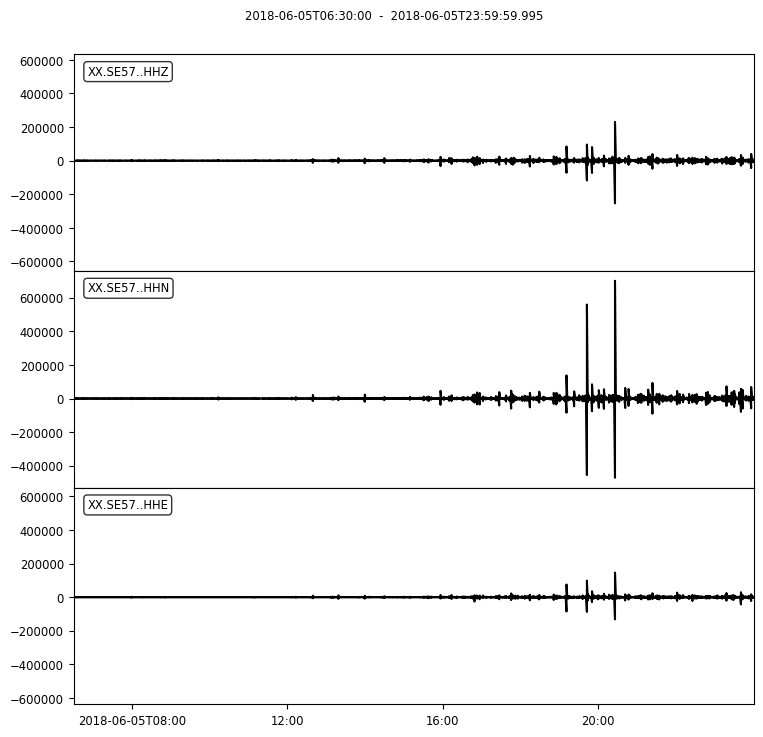

/opt/anaconda/envs/scatseisnet230330_cupy/lib/python3.11/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [6]:
stream.merge(method=1)
stream.detrend("linear")
stream.filter(type="highpass", freq=1.0)

# Downsample to 50 Hz
# stream.decimate(factor=10) # 500 sps 
# stream.decimate(factor=4) # 200 sps 
print(stream)
stream.plot(rasterized=True)

stream.write("../example/GL_scattering_stream.mseed", format="MSEED")

### Chunck seismograms

This stage allow to chunk the data into equal-length segments with a duration defined in the tutorial 1 notebook. For this we need to load the scattering network previously defined, so we make sure that the data segmentation corresponds to the loaded network.

Now we chunk the data with the `stream.slide` method. Note that for larger datasets, this should be adapted since this method is not optimal.

In [7]:
stream

3 Trace(s) in Stream:
XX.SE57..HHE | 2018-06-05T06:30:00.000000Z - 2018-06-05T23:59:59.995000Z | 200.0 Hz, 12600000 samples
XX.SE57..HHN | 2018-06-05T06:30:00.000000Z - 2018-06-05T23:59:59.995000Z | 200.0 Hz, 12600000 samples
XX.SE57..HHZ | 2018-06-05T06:30:00.000000Z - 2018-06-05T23:59:59.995000Z | 200.0 Hz, 12600000 samples

In [8]:
# Extract segment length (from any layer)
segment_duration = network.bins / network.sampling_rate
overlap = 0.5

# Gather list for timestamps and segments
timestamps = list()
segments = list()

# Collect data and timestamps
for traces in stream.slide(segment_duration, segment_duration * overlap):
    timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
    segments.append(np.array([trace.data[:-1] for trace in traces]))

## Scattering transformation

After collecting the data segments and the scattering network, we can now caclulate the scattering coefficients. Here we also set what kind of pooling we want to use by setting the `reduce_type` keyword argument to maximum (`max`) or average pooling (`avg`). 

In [9]:
len(segments)
# 8639*3

print(segments[0].shape)

(3, 4000)


In [11]:
scattering_coefficients = network.transform(segments[:-1], reduce_type=np.max)
# scattering_coefficients = network.transform(segments[:-1], reduce_type=np.average)

ValueError: operands could not be broadcast together with shapes (3, 4000) (10000,)

### Observe result from a single channel

In the following example one can observe the scattering coefficients.

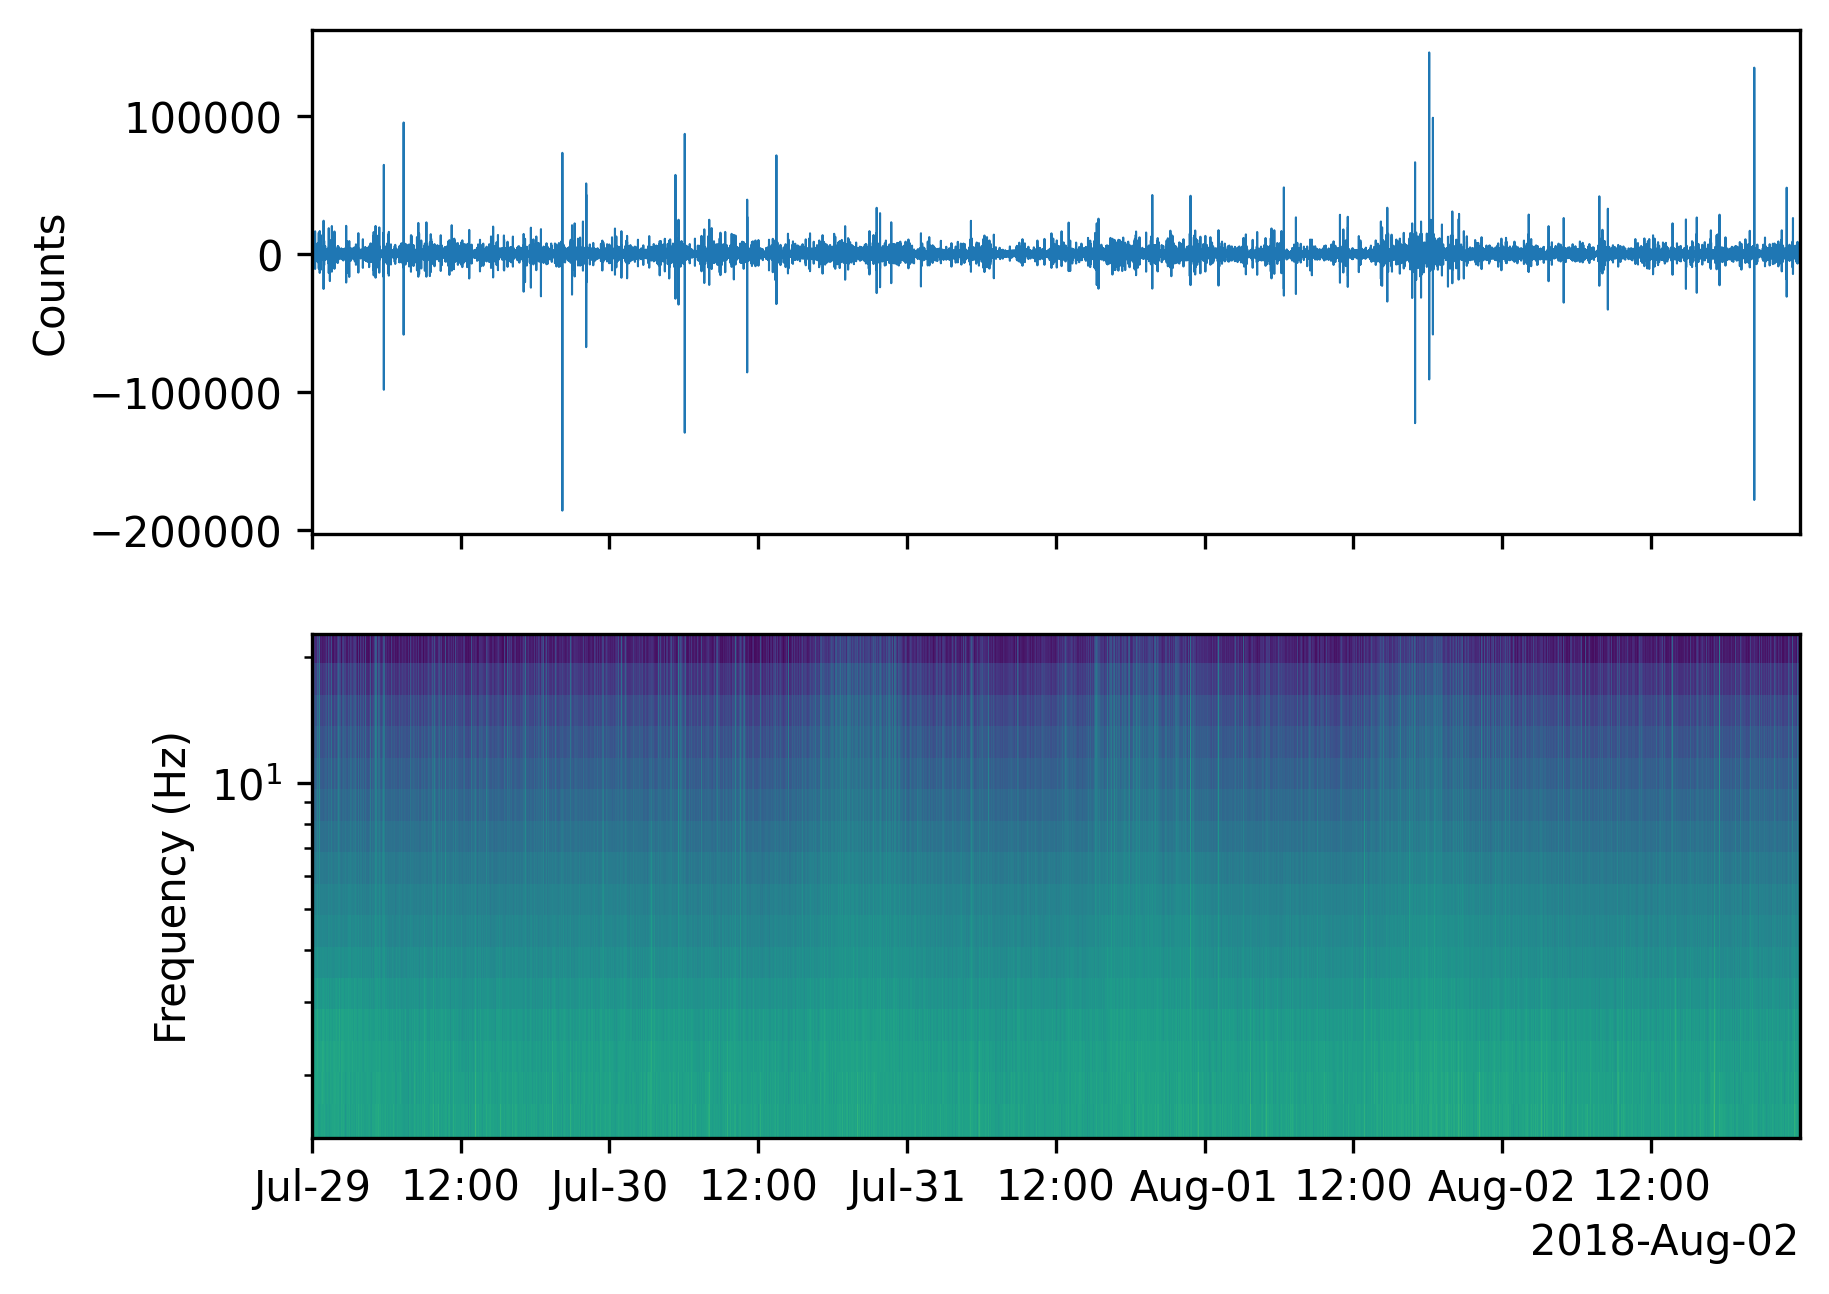

In [28]:
# Extract the first channel
channel_id = 0
trace = stream[channel_id]
order_1 = np.log10(scattering_coefficients[0][:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers

# Create figure and axes
fig, ax = plt.subplots(2, sharex=True, dpi=300)

# Plot the waveform
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# First-order scattering coefficients
ax[1].pcolormesh(timestamps[:-1], center_frequencies, order_1.T, rasterized=True)

# Axes labels
ax[1].set_yscale("log")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")

# Show
plt.show()

### Save outputs

Until now, we applied the scattering network to the three-component seismic data. In the next tutorial, we use the FastICA to extract the most relevant features from the scattering coefficients. Therefore, we save the first and second-order scattering coefficients as a npz-file.

In [30]:
np.savez(
    "../example/GL_scattering_coefficients_2.npz",
    order_1=scattering_coefficients[0],
    order_2=scattering_coefficients[1],
    times=timestamps,
)